<a href="https://colab.research.google.com/github/saigokhale/Social-Bias-in-ER/blob/main/ER_Resnet50_SFEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import tarfile
import cv2
import time


%matplotlib inline

FER 2013 Dataset from Kaggle

In [3]:
# import os
# link="https://www.kaggle.com/datasets/jayeshrohansingh/emotion-detection-dataset/download?datasetVersionNumber=1"
# #011960f626b19ef4ab6e3f9ffe8ba027
# od.download(link, force=True)


In [4]:
# import os
# link2="https://www.kaggle.com/datasets/mohammedaaltaha/expwds"
# #011960f626b19ef4ab6e3f9ffe8ba027
# od.download(link2, force=True)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
SFEW_ZIP="/content/drive/MyDrive/SCAAI/Demographic Bias in ER/SFEW_2.zip"

In [7]:
labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [8]:
# importing required modules
from zipfile import ZipFile
with ZipFile(SFEW_ZIP, 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()
	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall("/content/dataset")
	print('Done!')

File Name                                             Modified             Size
Test/SFEW_2_Test.zip                           2015-07-08 14:11:20    199060703
Test/Test_Aligned_Faces.zip                    2015-07-08 12:20:40     11029890
Test/Test_Aligned_Points.zip                   2015-07-08 12:55:12       248998
Test/Test_LPQ_Features.zip                     2015-07-08 12:22:44       467744
Test/Test_PHOG_Features.zip                    2015-07-08 12:19:32      7259705
Train/Angry.zip                                2015-05-17 00:14:22     96754962
Train/Disgust.zip                              2015-05-17 12:41:38     32233965
Train/Fear.zip                                 2015-05-17 13:06:54     41873696
Train/Happy.zip                                2016-10-12 17:15:44    119766884
Train/Neutral.zip                              2015-05-17 02:07:38     82149409
Train/Sad.zip                                  2015-05-17 12:25:48    101196826
Train/Surprise.zip                      

In [9]:
SFEW_SUB_ZIP_TRAIN="/content/dataset/Train"
SFEW_SUB_ZIP_TEST="/content/dataset/Test"
SFEW_SUB_ZIP_VAL="/content/dataset/Val"

In [10]:
for Emotion_ZIP in os.listdir(SFEW_SUB_ZIP_TRAIN):
  if(Emotion_ZIP[:-4] not in labels):
    continue
  with ZipFile(SFEW_SUB_ZIP_TRAIN+"/"+Emotion_ZIP, 'r') as zip:
    print(Emotion_ZIP)
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall("/content/dataset/train_extracted")
    print('Done!')

Happy.zip
Extracting all the files now...
Done!
Angry.zip
Extracting all the files now...
Done!
Disgust.zip
Extracting all the files now...
Done!
Neutral.zip
Extracting all the files now...
Done!
Surprise.zip
Extracting all the files now...
Done!
Fear.zip
Extracting all the files now...
Done!
Sad.zip
Extracting all the files now...
Done!


In [11]:
for Emotion_ZIP in os.listdir(SFEW_SUB_ZIP_VAL):
  if(Emotion_ZIP[:-4] not in labels):
    continue
  with ZipFile(SFEW_SUB_ZIP_VAL+"/"+Emotion_ZIP, 'r') as zip:
    print(Emotion_ZIP)
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall("/content/dataset/val_extracted")
    print('Done!')

Happy.zip
Extracting all the files now...
Done!
Angry.zip
Extracting all the files now...
Done!
Disgust.zip
Extracting all the files now...
Done!
Neutral.zip
Extracting all the files now...
Done!
Surprise.zip
Extracting all the files now...
Done!
Fear.zip
Extracting all the files now...
Done!
Sad.zip
Extracting all the files now...
Done!


In [12]:
DATA_DIR="/content/dataset"

In [13]:
pretrained_size = 224 # 48*48

train_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.RandomRotation(5),
                           tt.RandomHorizontalFlip(0.5),
                           tt.ToTensor()
                       ])

val_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.ToTensor()
                       ])

test_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.ToTensor(),
                       ])

In [14]:
train_ds = ImageFolder(DATA_DIR+'/train_extracted', train_transforms)
valid_ds = ImageFolder(DATA_DIR+'/val_extracted', val_transforms)
test_ds = ImageFolder(DATA_DIR+'/val_extracted', test_transforms)

In [15]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 958
Number of validation examples: 436
Number of testing examples: 436


In [16]:
BATCH_SIZE = 64
train_dl = DataLoader(train_ds,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_dl = DataLoader(valid_ds,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

test_dl = DataLoader(test_ds,
                                shuffle = True,
                                batch_size = BATCH_SIZE)


Angry


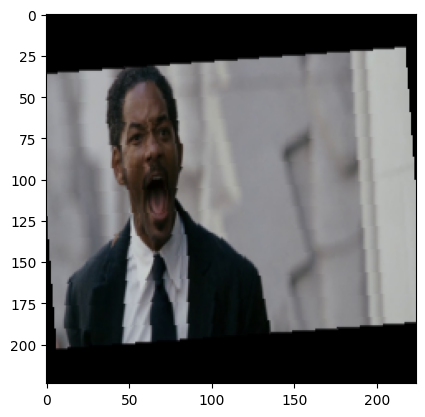

In [17]:
rand_idx=110
plt.imshow(train_ds[rand_idx][0].permute(1,2,0))
print(labels[train_ds[rand_idx][1]])

In [18]:
def show_batch(dl, class_labels):
  for images, label in dl:
      fig = plt.figure(figsize=(12, 12))
      for i in range(images.shape[0]):
        ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
        ax.imshow(images[i].permute(1,2,0))
        ax.set_title(sorted(class_labels)[label[i]])
      break

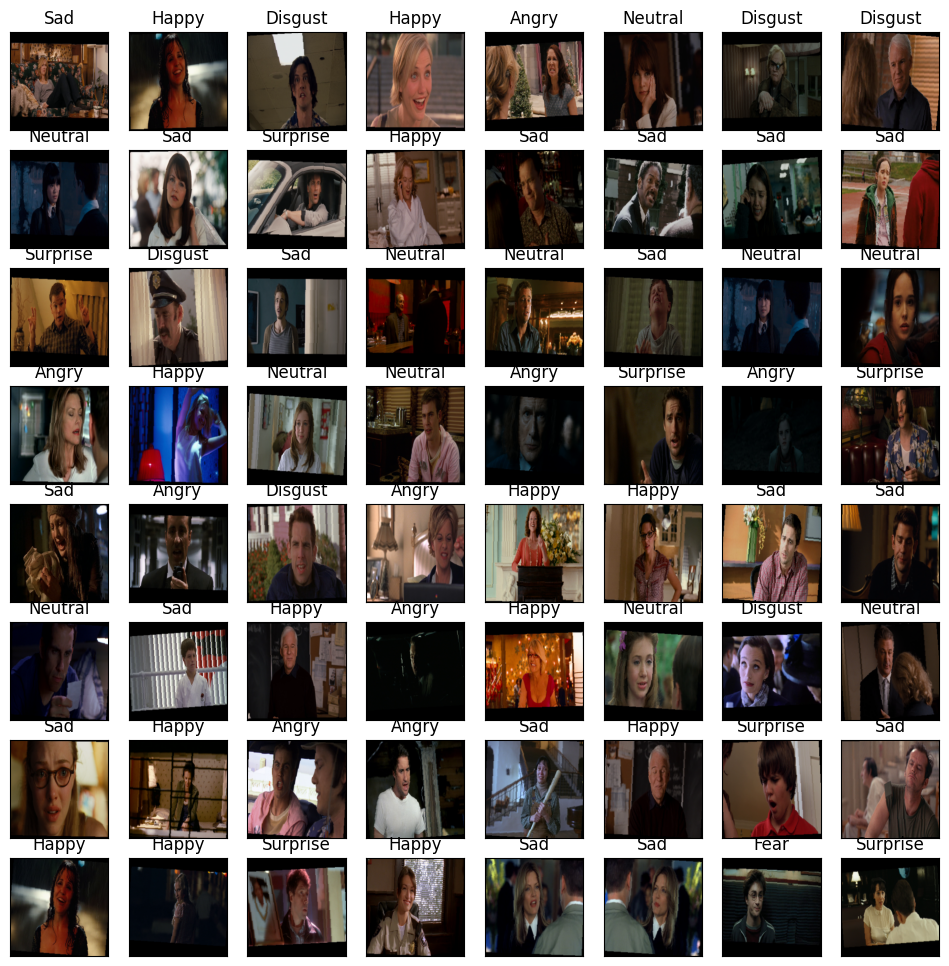

In [19]:
show_batch(train_dl, labels)


In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl2 = DeviceDataLoader(train_dl, device)
valid_dl2 = DeviceDataLoader(valid_dl, device)
test_dl2 = DeviceDataLoader(test_dl, device)

In [23]:
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ERBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
from torchvision import models

class ERModel(ERBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

    # def forward_hook(self,module,input,output):
    #     self.activation.append(output.detach().cpu().numpy())
    #     #print(self.activation)

    # def backward_hook(self,module,grad_in,grad_out):
    #     self.grad.append(grad_out[0].detach().cpu().numpy())
    #     #print(self.grad)

    # def generate_gradcam(self, image):
    #     self.network.eval()

    #     img, label=image
    #     # img=img
    #     img2=img

    #     img=img.to('cuda')
    #     img2=img2.to('cuda')

    #     target_layer= self.network.layer4[-1]

        # grad=[]
        # activation=[]

        # self.network.layer4[-1].register_forward_hook(self.forward_hook)
        # self.network.layer4[-1].register_backward_hook(self.backward_hook)

        # print(len(self.grad))
        # print(len(self.activation))


        # self.activation = []
        # self.grad = []

        # # forward pass to get activations
        # out=self.network(img.unsqueeze(0))

        # time.sleep(1)

        # loss_max=torch.argmax(out)
        # loss=out[0,loss_max]

        # # clear the gradients
        # self.network.zero_grad()

        # # backward pass to get gradients
        # # loss.backward()
        # # get the gradients and activations collected in the hook
        # grads=self.grad[0].data.numpy().squeeze()
        # fmap=self.activation[0].data.numpy().squeeze()

        # if(fmap.shape!=grads.shape):
        #   print("!!!Activation not matching Gradients!!!")
        #   print(fmap.shape)
        #   print(grads.shape)

        # tmp=grads.reshape([grads.shape[0],-1])
        # # Get the mean value of the gradients of every featuremap
        # weights=np.mean(tmp,axis=1)
        # cam = np.zeros(grads.shape[1:])
        # for i,w in enumerate(weights):
        #   cam += w*fmap[i,:]
        # cam=(cam>0)*cam
        # cam=cam/cam.max()*255

        # npic=np.array(torchvision.transforms.ToPILImage()(img2).convert('RGB'))
        # cam = cv2.resize(cam,(npic.shape[1],npic.shape[0]))
        # heatmap=cv2.applyColorMap(np.uint8(cam),cv2.COLORMAP_JET)
        # cam_img=npic*0.6+heatmap*0.4
        # display(torchvision.transforms.ToPILImage()(np.uint8(cam_img[:,:,::-1])))

In [26]:
model = ERModel(len(labels))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.3MB/s]


In [27]:
to_device(model, device);

In [28]:
history = [evaluate(model, valid_dl2)]
history

[{'val_loss': 2.025108575820923, 'val_acc': 0.1251717060804367}]

In [ ]:
# import random as rd
# def show_gradcam(model, test_ds):
#   random_idx=rd.randint(0, len(test_ds))
#   trial_image=test_ds[random_idx]
#   model.generate_gradcam(trial_image)
#   print(sorted(class_labels)[trial_image[1]])

In [ ]:
# show_gradcam(model, train_ds)

In [29]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl2, valid_dl2,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00260, train_loss: 1.9115, val_loss: 109.3411, val_acc: 0.1765


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00750, train_loss: 1.9485, val_loss: 3306.5715, val_acc: 0.1070


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 1.9747, val_loss: 413913.8125, val_acc: 0.1655


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 1.9920, val_loss: 56.2164, val_acc: 0.1157


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 1.8916, val_loss: 2.2122, val_acc: 0.1599


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 1.8611, val_loss: 1.9580, val_acc: 0.1978


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 1.8540, val_loss: 1.9369, val_acc: 0.1983


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 1.8345, val_loss: 1.9650, val_acc: 0.1626


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 1.8158, val_loss: 1.9622, val_acc: 0.1820


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 1.8073, val_loss: 1.9579, val_acc: 0.2088
CPU times: user 2min 5s, sys: 9.83 s, total: 2min 15s
Wall time: 2min 17s


In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl2, valid_dl2,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00260, train_loss: 1.8254, val_loss: 1.9406, val_acc: 0.1777


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00750, train_loss: 1.8595, val_loss: 37.6897, val_acc: 0.0742


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 1.8805, val_loss: 2.1538, val_acc: 0.1549


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 1.8857, val_loss: 2.2371, val_acc: 0.0958


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 1.8693, val_loss: 1.9703, val_acc: 0.1645


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 1.8536, val_loss: 1.9445, val_acc: 0.1781


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 1.8475, val_loss: 1.9508, val_acc: 0.1643


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 1.8334, val_loss: 1.9625, val_acc: 0.1775


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 1.8157, val_loss: 1.9496, val_acc: 0.1672


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 1.8202, val_loss: 1.9546, val_acc: 0.1937
CPU times: user 2min 8s, sys: 6.27 s, total: 2min 14s
Wall time: 2min 16s


In [ ]:
model2 = ERModel(len(labels))
to_device(model2, device)

In [31]:
epochs_2 = 10
lr_2 = 0.002
opt_func_2 = torch.optim.Adam

In [33]:
%%time
history += fit(epochs_2, lr_2, model2, train_dl2, valid_dl2, opt_func=opt_func_2)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.2247, val_loss: 27.0518, val_acc: 0.1791


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.9559, val_loss: 41.6943, val_acc: 0.1303


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.9492, val_loss: 1.9419, val_acc: 0.1686


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.9035, val_loss: 2.3411, val_acc: 0.1894


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.9069, val_loss: 1.9026, val_acc: 0.1626


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.8477, val_loss: 1.9314, val_acc: 0.1732


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.8415, val_loss: 2.4901, val_acc: 0.1781


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.8157, val_loss: 1.9954, val_acc: 0.1911


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.8352, val_loss: 2.3845, val_acc: 0.1497


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.7937, val_loss: 2.0557, val_acc: 0.1253
CPU times: user 2min 8s, sys: 5.9 s, total: 2min 14s
Wall time: 2min 18s


In [34]:
history += fit(epochs_2, lr_2, model2, train_dl2, valid_dl2, opt_func=opt_func_2)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.8720, val_loss: 96.2783, val_acc: 0.1799


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.8566, val_loss: 4.6798, val_acc: 0.1035


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.8270, val_loss: 1.9882, val_acc: 0.1087


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.7768, val_loss: 2.0395, val_acc: 0.1259


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.7675, val_loss: 2.1426, val_acc: 0.1514


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.7612, val_loss: 2.4240, val_acc: 0.1288


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.7734, val_loss: 2.0942, val_acc: 0.1949


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.7842, val_loss: 2.4543, val_acc: 0.1750


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.7335, val_loss: 2.0730, val_acc: 0.1435


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.7110, val_loss: 2.0319, val_acc: 0.1331
